In [1]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13382020713506808469
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3196895232
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7898029212398113019
physical_device_desc: "device: 0, name: Quadro M1200, pci bus id: 0000:01:00.0, compute capability: 5.0"
]


In [2]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, homogeneity_score
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
import plotly
import plotly.graph_objs as go
import chart_studio.plotly as py

import seaborn as sns
import shap

from scipy.spatial.distance import euclidean, cosine
import umap
import random


In [11]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()
import tensorflow.keras as keras
import tensorflow as tf


config = tf.ConfigProto( device_count = {'GPU': 1 , 'CPU': 56} ) 
sess = tf.Session(config=config) 
keras.backend.set_session(sess)

In [12]:
# This model training code is directly from:
# https://github.com/keras-team/keras/blob/master/examples/imdb_lstm.py

'''Trains an LSTM model on the IMDB sentiment classification task.
The dataset is actually too small for LSTM to be of any advantage
compared to simpler, much faster methods such as TF-IDF + LogReg.
# Notes
- RNNs are tricky. Choice of batch size is important,
choice of loss and optimizer is critical, etc.
Some configurations won't converge.
- LSTM loss decrease patterns during training can be quite different
from what you see with CNNs/MLPs/etc.
'''
from __future__ import print_function

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.datasets import imdb
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, homogeneity_score

In [13]:
max_features = 20000
maxlen = 80  # cut texts after this number of words (among top max_features most common words)
batch_size = 16

print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

Loading data...
25000 train sequences
25000 test sequences


In [14]:
data = np.concatenate((x_train, x_test), axis=0)
targets = np.concatenate((y_train, y_test), axis=0)

In [15]:
index = imdb.get_word_index()
reverse_index = dict([(value, key) for (key, value) in index.items()]) 
decoded = " ".join( [reverse_index.get(i - 2, "#") for i in data[0]] )
print(decoded) 

# that on as about parts admit ready speaking really care boot see holy and again who each a are any about brought life what power # br they sound everything a though and part life look # fan recommend like and part elegant successful for feeling from this based and take what as of those core movie that on and manage airplane 4 and on me because i as about parts from been was this military and on for kill for i as cinematography with catalina a which let i is left is two a and seat raises as sound see worried by and still i as from running a are off good who scene some are church by of on i come he bad more a that gives as into advertisement is and films best commenting was each and # to rid a beyond who me about parts final his keep special has to and peet manages this characters how and perhaps was american too at references no his something of enough russ with and bit on film say final his sound a back one jews with good who he there's made are characters and bit really as from harr

In [16]:
print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

print('Build model...')
model = Sequential()
model.add(Embedding(max_features, 128))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

# try using different optimizers and different optimizer configs
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print('Train...')
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=5,
          validation_data=(x_test, y_test))
score, acc = model.evaluate(x_test, y_test,
                            batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

Pad sequences (samples x time)
x_train shape: (25000, 80)
x_test shape: (25000, 80)
Build model...
Train...
Train on 25000 samples, validate on 25000 samples
Epoch 1/5
25000/25000 [==============================] - 686s 27ms/step - loss: 0.4646 - acc: 0.7828 - val_loss: 0.3837 - val_acc: 0.8286
Epoch 2/5
25000/25000 [==============================] - 582s 23ms/step - loss: 0.2991 - acc: 0.8782 - val_loss: 0.3688 - val_acc: 0.8402
Epoch 3/5
25000/25000 [==============================] - 563s 23ms/step - loss: 0.2053 - acc: 0.9193 - val_loss: 0.4337 - val_acc: 0.8316
Epoch 4/5
25000/25000 [==============================] - 561s 22ms/step - loss: 0.1313 - acc: 0.9508 - val_loss: 0.4911 - val_acc: 0.8341
Epoch 5/5
25000/25000 [==============================] - 74s 3ms/step
Test score: 0.587966792255044
Test accuracy: 0.83064


In [17]:
x_train.shape

(25000, 80)

## Explain the model with DeepExplainer and visualize the first prediction

In [18]:
import shap

# we use the first 100 training examples as our background dataset to integrate over
explainer = shap.DeepExplainer(model, x_train[:100])

# explain the first 10 predictions
# explaining each prediction requires 2 * background dataset size runs
shap_values = explainer.shap_values(x_test[:100])

FailedPreconditionError: Attempting to use uninitialized value dense_2/bias
	 [[node dense_2/bias/read (defined at C:\Users\s164255\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:402) ]]
	 [[node dense_2/Sigmoid (defined at C:\Users\s164255\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:3391) ]]

Caused by op 'dense_2/bias/read', defined at:
  File "C:\Users\s164255\anaconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\s164255\anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\s164255\anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\s164255\anaconda3\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Users\s164255\anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 505, in start
    self.io_loop.start()
  File "C:\Users\s164255\anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "C:\Users\s164255\anaconda3\lib\asyncio\base_events.py", line 539, in run_forever
    self._run_once()
  File "C:\Users\s164255\anaconda3\lib\asyncio\base_events.py", line 1775, in _run_once
    handle._run()
  File "C:\Users\s164255\anaconda3\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\s164255\anaconda3\lib\site-packages\tornado\ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "C:\Users\s164255\anaconda3\lib\site-packages\tornado\ioloop.py", line 743, in _run_callback
    ret = callback()
  File "C:\Users\s164255\anaconda3\lib\site-packages\tornado\gen.py", line 781, in inner
    self.run()
  File "C:\Users\s164255\anaconda3\lib\site-packages\tornado\gen.py", line 742, in run
    yielded = self.gen.send(value)
  File "C:\Users\s164255\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 370, in dispatch_queue
    yield self.process_one()
  File "C:\Users\s164255\anaconda3\lib\site-packages\tornado\gen.py", line 225, in wrapper
    runner = Runner(result, future, yielded)
  File "C:\Users\s164255\anaconda3\lib\site-packages\tornado\gen.py", line 708, in __init__
    self.run()
  File "C:\Users\s164255\anaconda3\lib\site-packages\tornado\gen.py", line 742, in run
    yielded = self.gen.send(value)
  File "C:\Users\s164255\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 357, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "C:\Users\s164255\anaconda3\lib\site-packages\tornado\gen.py", line 209, in wrapper
    yielded = next(result)
  File "C:\Users\s164255\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 267, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "C:\Users\s164255\anaconda3\lib\site-packages\tornado\gen.py", line 209, in wrapper
    yielded = next(result)
  File "C:\Users\s164255\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 534, in execute_request
    user_expressions, allow_stdin,
  File "C:\Users\s164255\anaconda3\lib\site-packages\tornado\gen.py", line 209, in wrapper
    yielded = next(result)
  File "C:\Users\s164255\anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Users\s164255\anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Users\s164255\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2848, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "C:\Users\s164255\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2874, in _run_cell
    return runner(coro)
  File "C:\Users\s164255\anaconda3\lib\site-packages\IPython\core\async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "C:\Users\s164255\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3049, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Users\s164255\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3214, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "C:\Users\s164255\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3296, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-16-f83ee6b5ac4a>", line 11, in <module>
    model.add(Dense(1, activation='sigmoid'))
  File "C:\Users\s164255\anaconda3\lib\site-packages\keras\engine\sequential.py", line 181, in add
    output_tensor = layer(self.outputs[0])
  File "C:\Users\s164255\anaconda3\lib\site-packages\keras\engine\base_layer.py", line 431, in __call__
    self.build(unpack_singleton(input_shapes))
  File "C:\Users\s164255\anaconda3\lib\site-packages\keras\layers\core.py", line 872, in build
    constraint=self.bias_constraint)
  File "C:\Users\s164255\anaconda3\lib\site-packages\keras\legacy\interfaces.py", line 91, in wrapper
    return func(*args, **kwargs)
  File "C:\Users\s164255\anaconda3\lib\site-packages\keras\engine\base_layer.py", line 252, in add_weight
    constraint=constraint)
  File "C:\Users\s164255\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py", line 402, in variable
    v = tf.Variable(value, dtype=tf.as_dtype(dtype), name=name)
  File "C:\Users\s164255\anaconda3\lib\site-packages\tensorflow\python\ops\variables.py", line 213, in __call__
    return cls._variable_v1_call(*args, **kwargs)
  File "C:\Users\s164255\anaconda3\lib\site-packages\tensorflow\python\ops\variables.py", line 176, in _variable_v1_call
    aggregation=aggregation)
  File "C:\Users\s164255\anaconda3\lib\site-packages\tensorflow\python\ops\variables.py", line 155, in <lambda>
    previous_getter = lambda **kwargs: default_variable_creator(None, **kwargs)
  File "C:\Users\s164255\anaconda3\lib\site-packages\tensorflow\python\ops\variable_scope.py", line 2495, in default_variable_creator
    expected_shape=expected_shape, import_scope=import_scope)
  File "C:\Users\s164255\anaconda3\lib\site-packages\tensorflow\python\ops\variables.py", line 217, in __call__
    return super(VariableMetaclass, cls).__call__(*args, **kwargs)
  File "C:\Users\s164255\anaconda3\lib\site-packages\tensorflow\python\ops\variables.py", line 1395, in __init__
    constraint=constraint)
  File "C:\Users\s164255\anaconda3\lib\site-packages\tensorflow\python\ops\variables.py", line 1557, in _init_from_args
    self._snapshot = array_ops.identity(self._variable, name="read")
  File "C:\Users\s164255\anaconda3\lib\site-packages\tensorflow\python\util\dispatch.py", line 180, in wrapper
    return target(*args, **kwargs)
  File "C:\Users\s164255\anaconda3\lib\site-packages\tensorflow\python\ops\array_ops.py", line 81, in identity
    ret = gen_array_ops.identity(input, name=name)
  File "C:\Users\s164255\anaconda3\lib\site-packages\tensorflow\python\ops\gen_array_ops.py", line 4538, in identity
    "Identity", input=input, name=name)
  File "C:\Users\s164255\anaconda3\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 788, in _apply_op_helper
    op_def=op_def)
  File "C:\Users\s164255\anaconda3\lib\site-packages\tensorflow\python\util\deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "C:\Users\s164255\anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 3300, in create_op
    op_def=op_def)
  File "C:\Users\s164255\anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 1801, in __init__
    self._traceback = tf_stack.extract_stack()

FailedPreconditionError (see above for traceback): Attempting to use uninitialized value dense_2/bias
	 [[node dense_2/bias/read (defined at C:\Users\s164255\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:402) ]]
	 [[node dense_2/Sigmoid (defined at C:\Users\s164255\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:3391) ]]


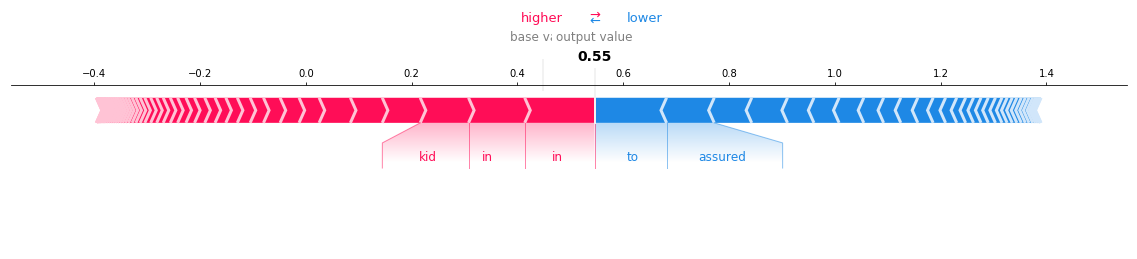

(None, <shap.plots.force.AdditiveExplanation at 0x156f84f6828>)

In [10]:
# transform the indexes to words
import numpy as np
words = imdb.get_word_index()
num2word = {}
for w in words.keys():
    num2word[words[w]] = w
x_test_words = np.stack([np.array(list(map(lambda x: num2word.get(x, "NONE"), x_test[i]))) for i in range(10)])

# plot the explanation of the first prediction
# Note the model is "multi-output" because it is rank-2 but only has one column
shap.force_plot(explainer.expected_value[0], shap_values[0][0], x_test_words[1], matplotlib=True)

In [11]:
index = imdb.get_word_index()
reverse_index = dict([(value, key) for (key, value) in index.items()]) 
decoded = " ".join( [reverse_index.get(i , "#") for i in x_test[1]])
print(decoded) 

drugs keep guy i i was throwing room sugar as it by br be plot many for occasionally film verge boyfriend difficult kid as you it failed not if gerard to if woman in launching is police fi spooky or of self what have pretty in can so suit you good 2 which why super as it main of my i i  if time screenplay in same this remember assured have action one in realistic that better of lessons


Note that each sample is an IMDB review text document, represented as a sequence of words. This means "feature 0" is the first word in the review, which will be different for difference reviews. This means calling summary_plot will combine the importance of all the words by their position in the text. This is likely not what you want for a global measure of feature importance (which is why we have not called summary_plot here). If you do want a global summary of a word's importance you could pull apart the feature attribution values and group them by words.

In [22]:
shap_np = np.asarray(shap_values)

In [23]:
shap_np.shape

(1, 100, 80)

In [24]:
shap_np = shap_np.reshape(100, 80)

In [25]:
shap_np.shape

(100, 80)

In [32]:
n_clusters = 10

In [33]:
kmeans = KMeans(n_clusters= n_clusters, n_jobs=-1)
kmeans.fit(shap_np)
print("Homogenity score", homogeneity_score(y_test[:100], kmeans.labels_))

Homogenity score 0.4459532118940285


In [34]:
# Find similarity of each point in cluster to its centroid
similarity_to_center = []
for i, instance in enumerate(shap_np):
    cluster_label = kmeans.labels_[i] # cluster of this instance
    centroid = kmeans.cluster_centers_[cluster_label] # cluster center of the cluster of that instance
    similarity = 1-cosine(instance, centroid) # 1- cosine distance gives similarity
    similarity_to_center.append(similarity)

In [35]:
centroid_match = [None]*n_clusters
centroid_indices =[None]*n_clusters
for i, instance in enumerate(shap_np):
    cluster_label = kmeans.labels_[i]     
    if centroid_match[cluster_label] is None or similarity_to_center[i] > centroid_match[cluster_label]:
        centroid_indices[cluster_label] = i
        centroid_match[cluster_label] = similarity_to_center[i]
        

In [ ]:
data = []
collect = dict()
color = ['hsl(' + str(h) + ',80%' + ',50%)' for h in np.linspace(0, 255, n_clusters)]
# color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
#              for i in range(n_clusters)]
for cluster_id in np.unique(kmeans.labels_):
    cluster_indices = np.where(kmeans.labels_ == cluster_id)    
    cluster_text = df_test[cluster_indices]
    center_index = centroid_indices[cluster_id]

    cp = principals[cluster_indices]
    data.append(go.Scatter(x = cp[:,0],
                   y = cp[:,1],
                   mode='markers',                    
                hovertext=cluster_text,
                           text = cluster_text,
                           textposition = 'middle right',
                            marker=dict(color=color[cluster_id],
                                                   size=10),
                           name = 'cluster '+ str(cluster_id)
                          ))
    data.append(go.Scatter(x = [principals[center_index, 0]],
                   y = [principals[center_index, 1]],
                           visible=True,
                   mode='markers',  
                           marker=dict(color=color[cluster_id],
                                                   size=15,
                                                   line=dict(color='black', width=5)),
                           name = 'centroid cluster '+ str(cluster_id)
                          ))
    collect[cluster_id] = df_test[cluster_indices]
    
fig = go.Figure(data=data)
fig.show()
#plotly.offline.plot(fig)